# Training a Classifier
Train on CIFAR10 dataset.  

Steps:

1. Load and Normalize dataset
1. Define a network
1. Define loss
1. Train
1. Test



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

> The output of torchvision datasets are PILImage images of range \[0, 1]. We transform them to Tensors of normalized range \[-1, 1\]

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(
    root = "./data",train = True, download = True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root = "./data",train = False, download = False, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


See some training images

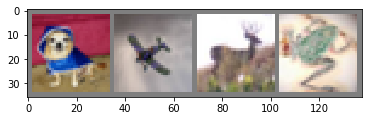

dog plane  deer  frog


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img * 0.5 + 0.5 # unnormalize
    npimg = img.numpy()
    # change from Ch * H * W to H * W * Ch 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get random images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(" ".join('%5s' % classes[labels[j]] for j in range(4)))

## Define a ConvNet

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Visualize the network.

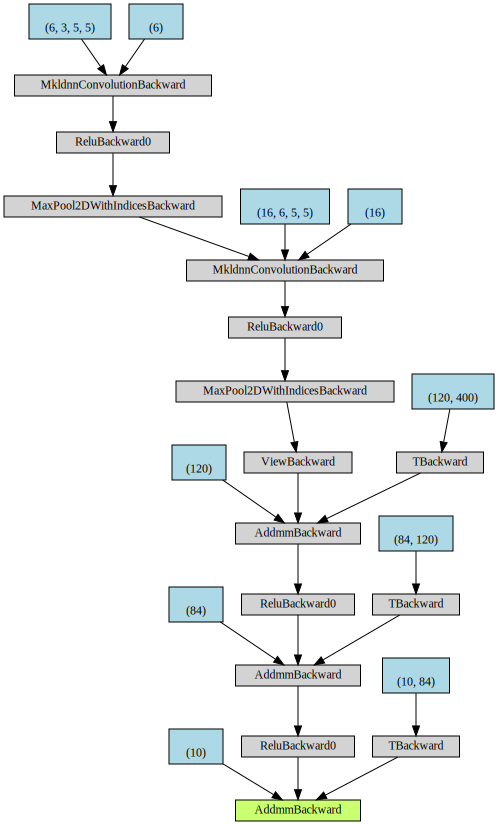

In [5]:
from torchviz import make_dot
# 1 image with dims Ch * H * W  = 3 * 32 * 32
input = torch.randn(1, 3, 32, 32)
out = net(input)
make_dot(out)

## Define a Loss function

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

## Train

In [7]:
import time

start_time = time.time()
for epoch in range(2): # go through the dada multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get inputs; data is a list [input, label]
        inputs, labels = data

        # zero grads
        optimizer.zero_grad()

        # forward + backward + optim
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # print statistics
        if i % 2000 == 0 and i != 0:
            print(f"Epoch: {epoch}\t i: {i}\t loss: {running_loss / 2000}\t Training time so far: {round((time.time() - start_time))}s")
            running_loss = 0.0

print("Finished training.")

Epoch: 0	 i: 2000	 loss: 2.216360142946243	 Training time so far: 43s
Epoch: 0	 i: 4000	 loss: 1.8243673751056195	 Training time so far: 99s
Epoch: 0	 i: 6000	 loss: 1.686692894116044	 Training time so far: 150s
Epoch: 0	 i: 8000	 loss: 1.5780528414100408	 Training time so far: 191s
Epoch: 0	 i: 10000	 loss: 1.5046480418741703	 Training time so far: 205s
Epoch: 0	 i: 12000	 loss: 1.4562853202968835	 Training time so far: 220s
Epoch: 1	 i: 2000	 loss: 1.3796473989114166	 Training time so far: 249s
Epoch: 1	 i: 4000	 loss: 1.3657707108333708	 Training time so far: 270s
Epoch: 1	 i: 6000	 loss: 1.3385926609970629	 Training time so far: 288s
Epoch: 1	 i: 8000	 loss: 1.293660290841013	 Training time so far: 307s
Epoch: 1	 i: 10000	 loss: 1.3071596032604575	 Training time so far: 328s
Epoch: 1	 i: 12000	 loss: 1.2769088573083283	 Training time so far: 345s
Finished training.


Save trained model

In [8]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

## Test

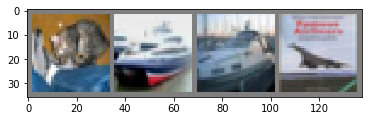

Ground Truth: cat ship ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("Ground Truth:", " ".join("%s" % classes[labels[j]] for j in range(4)))

### Load the saved model

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

argmax and torch.max

In [11]:
outputs = net(images)
idxs = outputs.argmax(axis=1)
print(idxs)
print('Predicted:', ' '.join('%s' % classes[j] for j in idxs))

tensor([3, 8, 8, 0], grad_fn=<NotImplemented>)
Predicted: cat ship ship plane


In [12]:
_, predicted = torch.max(outputs, 1)
print(_)
print('Predicted:', ' '.join('%s' % classes[predicted[j]] for j in range(4)))

tensor([2.0693, 6.2829, 3.4890, 2.6221], grad_fn=<MaxBackward0>)
Predicted: cat ship ship plane


Eval on the entire test

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy of the network is: {100*correct/total} %")

Accuracy of the network is: 56.08 %


On what classes did the model perform well

In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f"Accuracy of the class {classes[i]}:\t {100*class_correct[i]/class_total[i]}%")

Accuracy of the class plane:	 49.4%
Accuracy of the class car:	 71.6%
Accuracy of the class bird:	 39.1%
Accuracy of the class cat:	 31.2%
Accuracy of the class deer:	 48.5%
Accuracy of the class dog:	 52.8%
Accuracy of the class frog:	 75.0%
Accuracy of the class horse:	 60.9%
Accuracy of the class ship:	 70.0%
Accuracy of the class truck:	 62.3%


## Train on GPU

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Convert modules to run on GPU

In [16]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Train loop on GPU

In [17]:
start_time = time.time()

for epoch in range(2): # go through the dada multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get inputs; data is a list [input, label]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero grads
        optimizer.zero_grad()

        # forward + backward + optim
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # print statistics
        if i % 2000 == 0 and i != 0:
            print(f"Epoch: {epoch}\t i: {i}\t loss: {running_loss / 2000}\t Training time so far: {round((time.time() - start_time))}s")
            running_loss = 0.0

print("Finished training.")

Epoch: 0	 i: 2000	 loss: 1.2056387576013803	 Training time so far: 18s
Epoch: 0	 i: 4000	 loss: 1.1857069364637136	 Training time so far: 32s
Epoch: 0	 i: 6000	 loss: 1.169511442616582	 Training time so far: 47s
Epoch: 0	 i: 8000	 loss: 1.1715777965039016	 Training time so far: 70s
Epoch: 0	 i: 10000	 loss: 1.174921576693654	 Training time so far: 94s
Epoch: 0	 i: 12000	 loss: 1.1628919189572335	 Training time so far: 113s
Epoch: 1	 i: 2000	 loss: 1.1884763893485069	 Training time so far: 131s
Epoch: 1	 i: 4000	 loss: 1.1690971160233021	 Training time so far: 145s
Epoch: 1	 i: 6000	 loss: 1.1877625092715025	 Training time so far: 162s
Epoch: 1	 i: 8000	 loss: 1.1934060196727514	 Training time so far: 177s
Epoch: 1	 i: 10000	 loss: 1.1668617019057275	 Training time so far: 199s
Epoch: 1	 i: 12000	 loss: 1.1600288445204496	 Training time so far: 244s
Finished training.
